In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100

In [3]:
swaption

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400
9,5Y,10Y,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250


In [4]:
swap = swaption.set_index(['Expiry', 'Tenor'])

In [5]:
bps = np.array([0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))])

In [6]:
bps

array([-0.02  , -0.015 , -0.01  , -0.005 , -0.0025,  0.    ,  0.0025,
        0.005 ,  0.01  ,  0.015 ,  0.02  ])

In [7]:
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0) #forward swap rate
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [8]:
semi_annual_DF = pd.read_csv('discount_factor.csv', header = 0, index_col = 0).reset_index()

In [9]:
semi_annual_DF.tail()

,Tenor,OIS_DF,Libor_DF
55,28.0,0.857941,0.260573
56,28.5,0.855307,0.251346
57,29.0,0.852674,0.242118
58,29.5,0.850040,0.232890
59,30.0,0.847407,0.223662


In [10]:
yearly_DF = pd.read_csv('yearly_DF.csv', header = 0, index_col = 0)
yearly_DF.tail()

,Tenor,OIS_DF,Libor_DF
51,26.0,0.868474,0.297484
53,27.0,0.863207,0.279029
55,28.0,0.857941,0.260573
57,29.0,0.852674,0.242118
59,30.0,0.847407,0.223662


In [11]:
# F: Forward price
# K: Strike price
# sigma: volatility
# pvbp: present value of bips point

def Black76Call(F, K, sigma, pvbp, T):    
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD_Put(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Put(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

In [12]:
def Black76(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if F <= K:
        black_price =  pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))
    else:
        black_price =  pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    return black_price


def DD(F, K, sigma, pvbp, beta, T):
    if F <= K:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    else:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Put(F_d, K_d, sigma_d, pvbp, T)
        
    return price

In [13]:
#sigma beta for paramaterization
def Implied_Vol(F, K, pvbp, T, sigma, beta):
    
    #price = DD(F, K, sigma, pvbp, beta, T)
    # x: is the implied vol we are looking for
    
    if F <= K:
        price = DD_Call(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = DD_Put(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K, x, pvbp, T),
                        0.5)
    return vol[0]

In [14]:
def ddcalibration(beta,  F, strikes, vols, pvbp,  T):
    err = 0.0
    sigma = vols[5]
    #Sigma here we use the at the money strike
    
    for i, vol in enumerate(vols):
        
        err += (vol - Implied_Vol( F, strikes[i], pvbp,  T, sigma, beta))**2

    return err

## 1. Calibration the DD model

In [15]:
Expiry=['1Y','5Y','10Y']
Tenor=['1Y','2Y','3Y','5Y','10Y']

In [16]:
initialGuess = [0.3]

In [17]:
Cal_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
Cal_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [18]:
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te] #get the forward swap rate
        market_vol = swap.loc[(ex, te), :].values #get the vols at the fsr
        strikes = fwd + bps #the corresoponding fsr rate at different strike K
        
        ex_int = int(ex.strip()[:-1]) 
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        
        res = least_squares(lambda bet: ddcalibration(bet, fwd, strikes, 
                                                    market_vol, pvbp, T = ex_int), initialGuess,
                                                    bounds=([0,1]))
    
        
        
        Cal_Beta[te][ex]= res.x
        Cal_Sigma[te][ex]= market_vol[5]

In [19]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [20]:
Cal_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,3.687890e-08,3.759441e-13,1.307398e-07,0.000004,0.000007
5Y,1.354602e-12,5.502017e-08,2.277269e-06,0.000143,0.055462
10Y,1.396185e-07,7.489769e-06,8.155023e-05,0.000001,0.001745


## 2. SABR calibration

In [21]:
beta = 0.9

In [22]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    # x here is the alpha beta pho 
    err = 0.0
    
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

In [23]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [24]:
initialGuess_sabr=[0.1,-0.5,0.5]

In [25]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
    
        T=int(ex[:-1])
       
        res=least_squares(lambda x: sabrcalibration(x,
                                           strikes,
                                           market_vol,
                                           fwd,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [26]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139070,0.184647,0.196851,0.178052,0.170737
5Y,0.166512,0.199504,0.210345,0.190991,0.177188
10Y,0.177461,0.195188,0.207149,0.201652,0.180368


In [27]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633211,-0.525116,-0.482846,-0.414426,-0.261814
5Y,-0.585175,-0.546913,-0.549766,-0.510955,-0.438585
10Y,-0.545522,-0.544258,-0.550704,-0.562765,-0.508457


In [28]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049441,1.677422,1.438134,1.064877,0.782229
5Y,1.339641,1.061939,0.936720,0.671796,0.495874
10Y,1.006910,0.925321,0.868993,0.719546,0.579353


In [29]:
def sabrvol(F, K, pvbp, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76Call(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = Black76Put(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

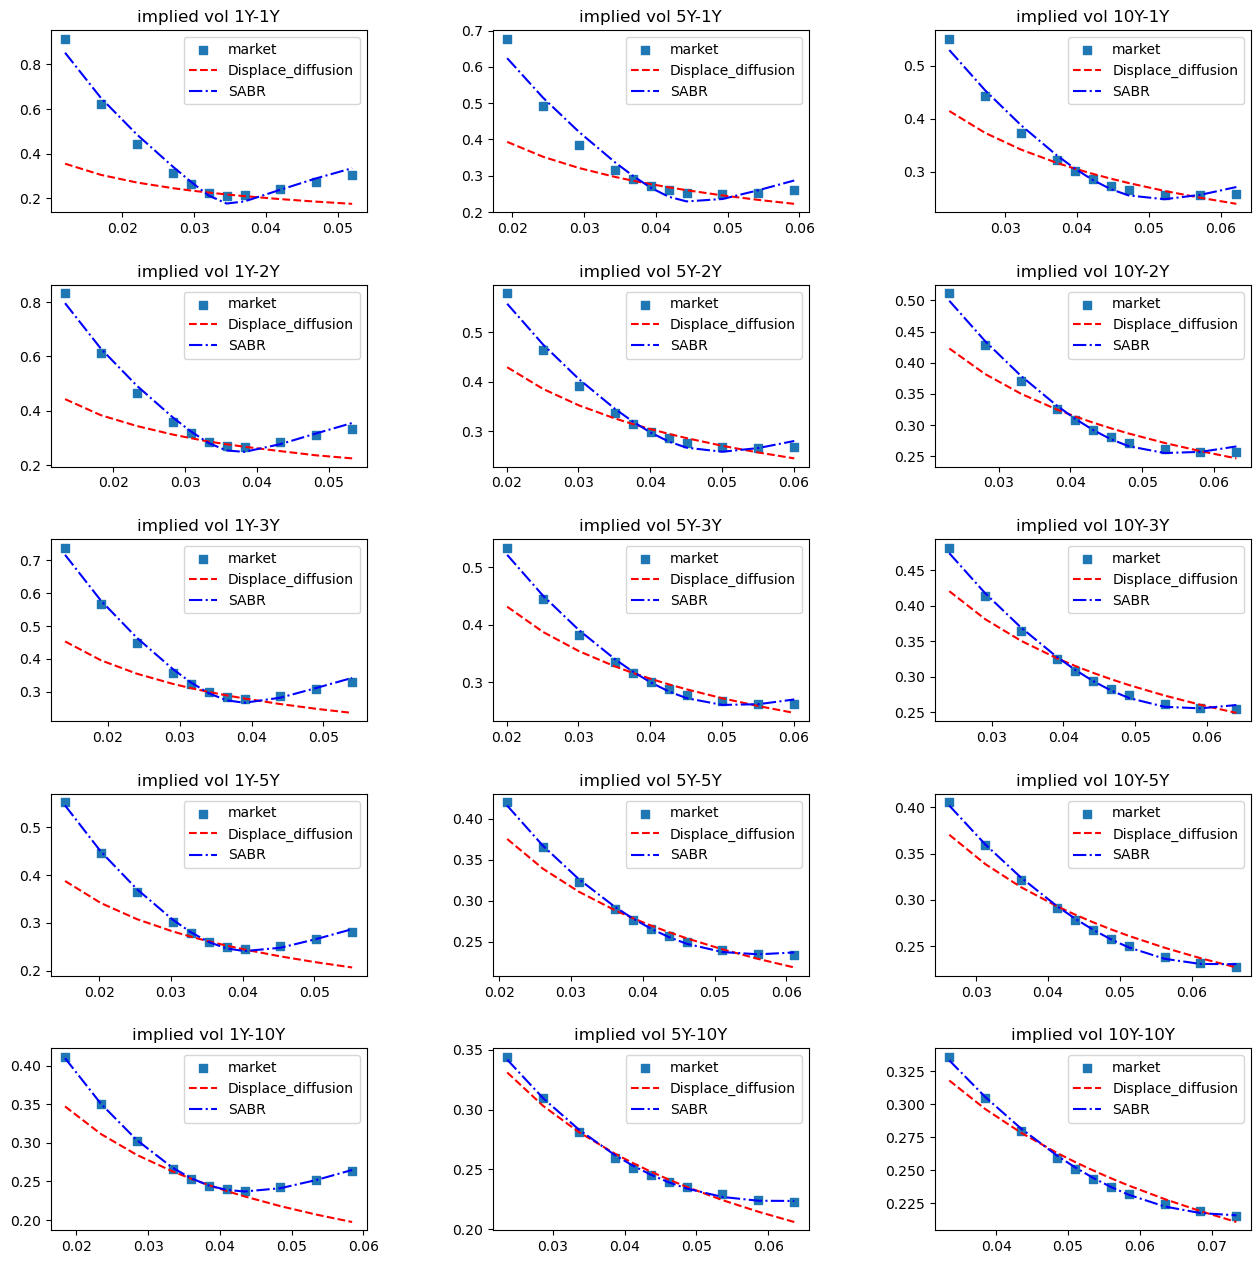

In [49]:
# plot the DD model and SABR model
fig, axs = plt.subplots(5, 3, figsize=(15, 15))  # 5 rows, 3 columns
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for ex in Expiry:
    for te in Tenor:
        ex_index = Expiry.index(ex)
        te_index = Tenor.index(te)
#         print(te_index, ex_index)
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [Implied_Vol(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        SABR_vols = [sabrvol(fwd, i, pvbp, T, SABR_Alpha.loc[ex,te], 0.9,
                             SABR_Rho.loc[ex, te], SABR_Nu.loc[ex, te]) for i in strikes]
        
        axs[te_index,ex_index].scatter(strikes, market_vols,marker = 's', label= 'market')
        axs[te_index,ex_index].plot(strikes, DD_vols, '--r', label = 'Displace_diffusion')
        axs[te_index,ex_index].plot(strikes, SABR_vols, '-.b', label = 'SABR')
        axs[te_index,ex_index].legend()
        axs[te_index,ex_index].set_title('implied vol '+ex+'-'+te)
plt.savefig('fitting.png')   
plt.show()


In [31]:
SABR_Alpha.to_csv('sabr_alpha.csv')
SABR_Rho.to_csv('sabr_rho.csv')
SABR_Nu.to_csv('sabr_nu.csv')

## 3. Price the swaptions using calibrated Displaced-diffusion and SABR model

In [32]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [33]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [34]:
Cal_Sigma.loc['1Y','10Y']

0.2447

In [35]:
sigma = interpol(1,Cal_Sigma.loc['1Y','10Y'],5,Cal_Sigma.loc['5Y']['10Y'],2)
beta = interpol(1,Cal_Beta.loc['1Y','10Y'],5,Cal_Beta.loc['5Y']['10Y'],2)

In [36]:
alpha=interpol(1,SABR_Alpha.loc['1Y','10Y'],5,SABR_Alpha.loc['5Y']['10Y'],2)
rho=interpol(1,SABR_Rho.loc['1Y','10Y'],5,SABR_Rho.loc['5Y']['10Y'],2)
nu=interpol(1,SABR_Nu.loc['1Y','10Y'],5,SABR_Nu.loc['5Y']['10Y'],2)

In [37]:
# for payer 2y x 10y
# get 2x10 forward swap rate

df = pd.read_csv('discount_factor.csv')
deno = 0.5*sum(df.OIS_DF[2*2:2*(2+10)])       
terms = []
for x in range(2*2, 2*(2+10)):
    no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x] # forward libor L(1,1.5)*0.5 = D(0,1)-D(0,1.5)
    terms.append(no)
numer = sum(terms)

fwd1 = numer/deno
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = 0.5 * sum(semi_annual_DF.OIS_DF[2*2:(2+10)*2])

In [38]:
fwd1, pvbp1

(0.03963437677316925, 9.699535688510334)

In [39]:
payer_DD = [DD_Call(fwd1, k, sigma, pvbp1, beta, T) for k in strikes]    

In [40]:
payer_SABR=[Black76Call(fwd1,k,SABR(fwd1,k,T,alpha,0.9,rho,nu),pvbp1, T) for k in strikes]

In [41]:
payer = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR})
payer

,Strikes,Displaced Diffusion,SABR
0,0.01,0.288142,0.289629
1,0.02,0.194936,0.198340
2,0.03,0.112326,0.115194
3,0.04,0.051345,0.052129
4,0.05,0.017366,0.021395
5,0.06,0.004106,0.010798
6,0.07,0.000651,0.006686
7,0.08,0.000067,0.004703


In [42]:
# for receiver 8x10y
deno = 0.5*sum(df.OIS_DF[2*8:2*(8+10)])        
terms = []
for x in range(2*8, 2*(8+10)):
    no = df.OIS_DF[x] * (df.Libor_DF[x-1] - df.Libor_DF[x])/df.Libor_DF[x]
    terms.append(no)
numer = sum(terms)

fwd2 = numer/deno
pvbp2 = 0.5 * sum(semi_annual_DF.OIS_DF[8*2:(8+10)*2])
T = 8

In [43]:
fwd2, pvbp2

(0.04871114894211797, 9.375969869808888)

In [44]:
sigma = interpol(5,Cal_Sigma['10Y']['5Y'],10,Cal_Sigma['10Y']['10Y'],8)
beta = interpol(5,Cal_Beta['10Y']['5Y'],10,Cal_Beta['10Y']['10Y'],8)

In [45]:
alpha=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

In [46]:
rec_DD = [DD_Put(fwd2, i, sigma, pvbp2, beta, T) for i in strikes]
rec_SABR=[Black76Put(fwd2, i, SABR(fwd2,i,T,alpha,0.9,rho,nu), pvbp2, T) for i in strikes]

In [47]:
receiver = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR})
receiver

,Strikes,Displaced Diffusion,SABR
0,0.01,0.018985,0.019275
1,0.02,0.033904,0.038457
2,0.03,0.056649,0.061136
3,0.04,0.088980,0.090230
4,0.05,0.132050,0.130273
5,0.06,0.186136,0.186080
6,0.07,0.250582,0.257353
7,0.08,0.323971,0.338598
